In [44]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools

os.chdir('/home/brian/Documents/CPS/data/clean/')

# Graph settings
plt.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.titleweight': 'medium', 
                     'font.weight': 'regular'})
plt.rc('font', family='Lato')

In [106]:
sex = {0: 'Men', 1: 'Women'}

ages = [(25, 34), (35, 44), (45, 54)]

age_list = [f'{age_min}-{age_max}' for age_min, age_max in ages]

groups = [(f'{sex[i]} {age}', i, int(age[0:2]), int(age[3:5])) 
          for age, i in itertools.product(age_list, [0, 1])]

queries = [(name, f'{age_min} <= AGE <= {age_max} and FEMALE == {sex}') 
           for name, sex, age_min, age_max in groups]

cols = ['YEAR', 'AGE', 'FEMALE', 'LFS', 'NILFREASON', 'BASICWGT', 'MONTH']

other = ['Other', 'Retired']

calcs = [('Employed', 'LFS', 'Employed'),
         ('Unemployed', 'LFS', 'Unemployed'),
         ('NILF', 'LFS', 'NILF'),
         ('School', 'NILFREASON', 'School'),
         ('Discouraged', 'NILFREASON', 'Discouraged'),
         ('Retired', 'NILFREASON', 'Retired'),
         ('Disabled/Ill', 'NILFREASON', 'Disabled/Ill'),
         ('Caring for Family/Household', 'NILFREASON', 'Family'),
         ('Other', 'NILFREASON', 'Other')]

In [107]:
annual_data = []
for year in range(1999, 2020):
    for month in range(1, 13):
        df = (pd.read_feather(f'cps{year}.ft', columns=cols)
                .query('MONTH == @month'))
        date = pd.to_datetime(f'{year}-{month}-01')
        for name, query in queries:
            data = df.query(query)
            total = data.BASICWGT.sum()
            for calc_name, group_var, var in calcs:
                result = data.groupby(group_var).BASICWGT.sum()[var]
                value = (name, calc_name, date, result / total * 100)
                annual_data.append(value)

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in float_scalars
  if sys.path[0] == '':


In [111]:
final = pd.DataFrame(annual_data)
final.columns = ['group', 'category', 'date', 'value']

d = {}
for name, query in queries:
    dft = (final.query(f'group == "{name}"')
                .pivot(index='date', columns='category', values='value'))
    dft = dft[['Unemployed', 'NILF']]
    dft = dft.rolling(12).mean().dropna()
    dft = dft - dft.iloc[0]
    d[name] = dft

In [113]:
colors = ['#a6cee3', '#1f78b4']

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01')]

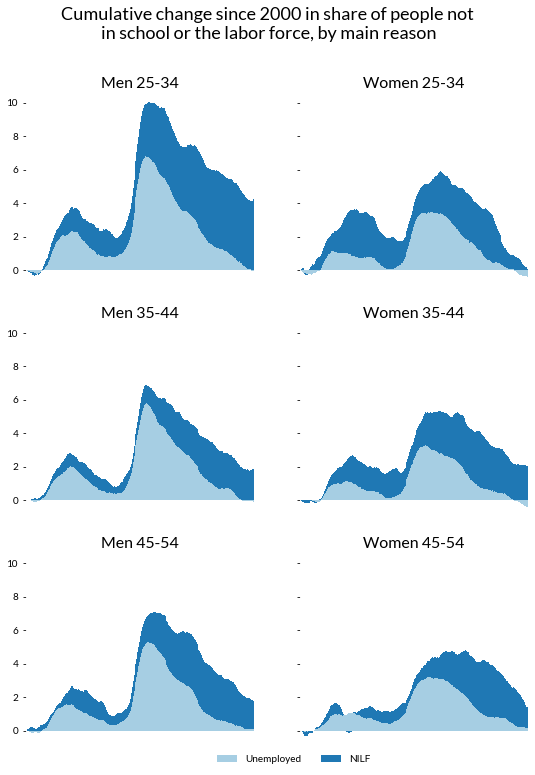

In [114]:
fig, axes = plt.subplots(nrows=len(ages), ncols=2, figsize=(9,12), sharey=True)
for i, ax in enumerate(axes.flatten()):
    d[queries[i][0]].plot(
        kind='bar', stacked=True, ax=ax, legend=None, width=1.0,
        color=colors)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_title(queries[i][0])
ax.legend(bbox_to_anchor=(0.35, 0.0), ncol=2, frameon=False)
fig.suptitle('Cumulative change since 2000 in share of people not \nin school or the labor force, by main reason', fontsize=18);